In [2]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap
import IPython.display as ipd
from gtts import gTTS
import torch
import torchaudio
from torchaudio.pipelines import TACOTRON2_WAVERNN_PHONE_LJSPEECH

bundle = TACOTRON2_WAVERNN_PHONE_LJSPEECH

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [3]:
image_path = 'C:/image_caption_generator/archive/Images'
data = pd.read_csv("C:/image_caption_generator/archive/captions.txt")
data.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


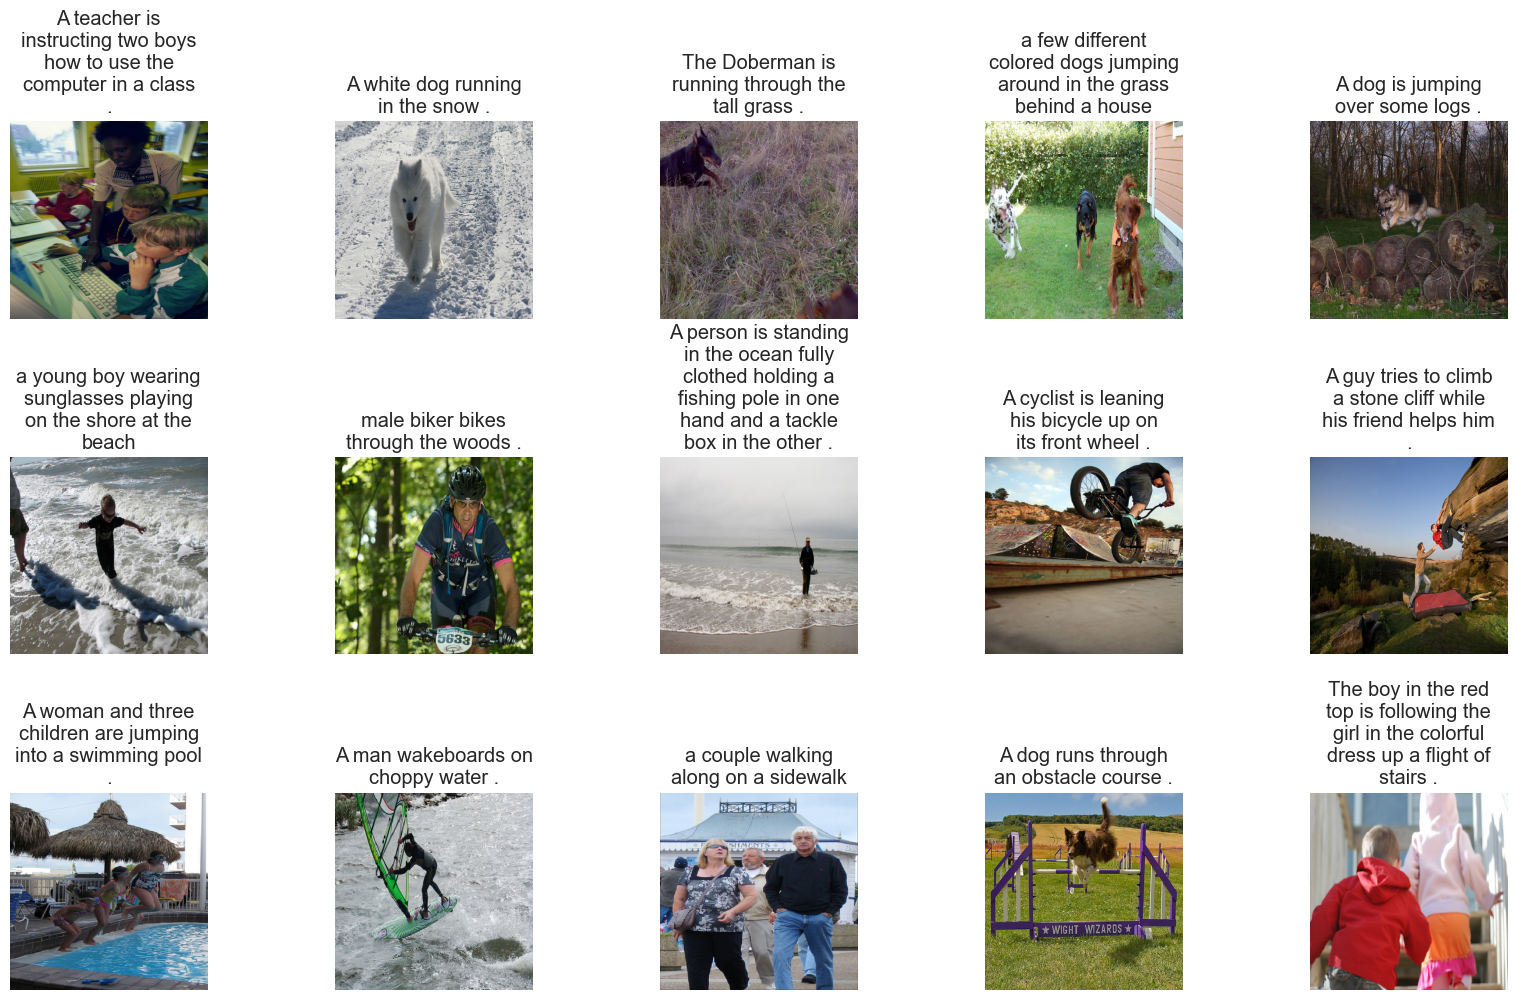

In [4]:
def readImage(path,img_size=512):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"C:/image_caption_generator/archive/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

display_images(data.sample(15))

In [5]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data 
data = text_preprocessing(data)

captions = data['caption'].tolist()

captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [6]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [7]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224  # Set to 224 to match model input size
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img_path = os.path.join(image_path, image)

    # Load and resize image correctly
    img = load_img(img_path, target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img / 255.0
    img = np.expand_dims(img, axis=0)

    feature = fe.predict(img, verbose=0)
    features[image] = feature


100%|██████████| 8091/8091 [34:37<00:00,  3.89it/s]


In [8]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [9]:
train_generator[0]

((array([[7.8687954e-05, 7.3524070e-04, 1.1395994e-03, ..., 5.6523442e-01,
          2.2903764e-01, 6.9639963e-01],
         [7.8687954e-05, 7.3524070e-04, 1.1395994e-03, ..., 5.6523442e-01,
          2.2903764e-01, 6.9639963e-01],
         [7.8687954e-05, 7.3524070e-04, 1.1395994e-03, ..., 5.6523442e-01,
          2.2903764e-01, 6.9639963e-01],
         ...,
         [1.9476049e-04, 7.0213008e-04, 1.4947485e-03, ..., 2.7233645e-02,
          5.5759478e-01, 3.8916609e-01],
         [1.9476049e-04, 7.0213008e-04, 1.4947485e-03, ..., 2.7233645e-02,
          5.5759478e-01, 3.8916609e-01],
         [1.9476049e-04, 7.0213008e-04, 1.4947485e-03, ..., 2.7233645e-02,
          5.5759478e-01, 3.8916609e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

In [10]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)




history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 524ms/step - loss: 5.7062
Epoch 1: val_loss improved from inf to 4.28957, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 307s 566ms/step - loss: 5.7051 - val_loss: 4.2896 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 535ms/step - loss: 4.3329
Epoch 2: val_loss improved from 4.28957 to 3.97921, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 309s 575ms/step - loss: 4.3328 - val_loss: 3.9792 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 536ms/step - loss: 4.0244
Epoch 3: val_loss improved from 3.97921 to 3.82726, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 309s 576ms/step - loss: 4.0244 - val_loss: 3.8273 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 523ms/step - loss: 3.8519
Epoch 4: val_loss improved from 3.82726 to 3.73910, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 302s 562ms/step - loss: 3.8519 - val_loss: 3.7391 - learning_rate: 0.0

In [12]:
model.save('model.h5')


In [13]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [14]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle
from gtts import gTTS
import IPython.display as ipd

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"



In [15]:

def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()
   
    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()
    
    return caption




In [16]:
# Function to generate speech using gTTS
def text_to_speech_gtts(text, lang='en'):
    tts = gTTS(text=text, lang=lang)
    tts.save("output.mp3")
    return "output.mp3"


def text_to_speech_tacotron(text):
    bundle = TACOTRON2_WAVERNN_PIPELINE  # Load Tacotron2 + WaveRNN model
    processor = bundle.get_text_processor()
    model = bundle.get_tacotron2()
    vocoder = bundle.get_vocoder()
    
    with torch.no_grad():
        processed, lengths = processor(text)
        mel_spec, _ = model.infer(processed, lengths)
        waveforms = vocoder(mel_spec)
    
    return waveforms.squeeze().numpy()



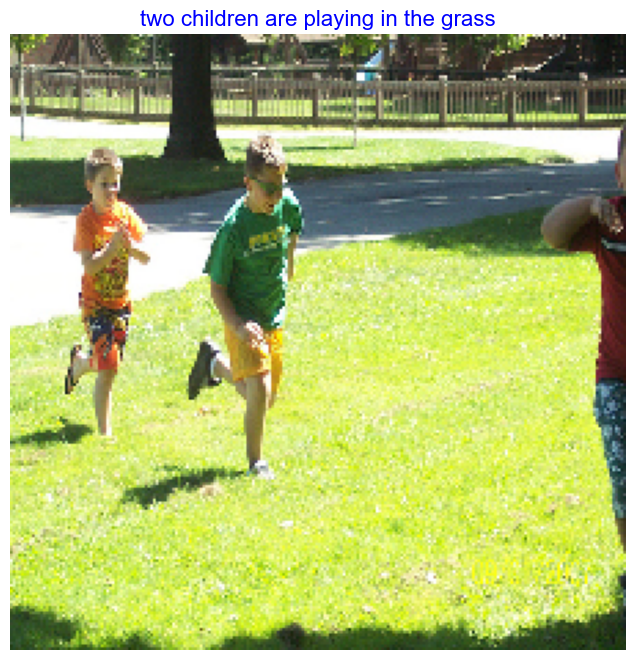

In [32]:
# Path to image

image_path = "C:/image_caption_generator/archive/Images/1449370354_380c4123c9.jpg"

# Generate the caption
caption = generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

# Convert the caption to speech
mp3_file = text_to_speech_gtts(caption)
ipd.display(ipd.Audio(mp3_file, autoplay=True))

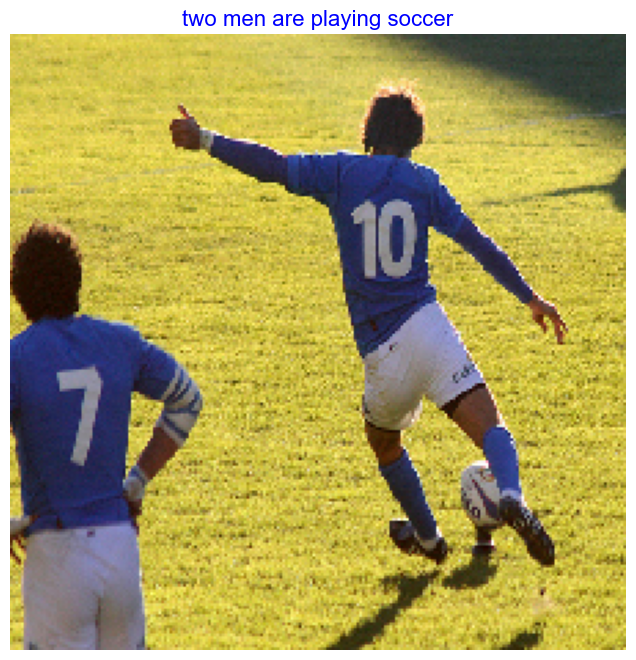

In [ ]:
image_path = "C:/sample project/images/Images/3050650135_23f9d9d2f8.jpg"
# Generate the caption
caption = generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)
# Convert the caption to speech
mp3_file = text_to_speech_gtts(caption)
ipd.display(ipd.Audio(mp3_file, autoplay=True))

In [31]:
from nltk.translate.bleu_score import corpus_bleu
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
import os

def calculate_accuracy(actual_captions, predicted_captions):
    correct_words = 0
    total_words = 0
    
    for actual, predicted in zip(actual_captions, predicted_captions):
        actual_words = actual.split()
        predicted_words = predicted.split()
        total_words += len(actual_words)
        correct_words += sum(a == b for a, b in zip(actual_words, predicted_words))
    
    return correct_words / total_words if total_words > 0 else 0

def evaluate_model(model, tokenizer, feature_extractor, test, max_length, image_directory):
    actual_captions = []
    predicted_captions = []
    references = []
    hypotheses = []
    
    for i in range(len(test)):
        image_name = test.iloc[i]['image']
        image_path = os.path.join(image_directory, image_name)  # Fixed issue here
        captions = test[test['image'] == image_name]['caption'].tolist()
        
        img = load_img(image_path, target_size=(224, 224))
        img = img_to_array(img) / 255.0
        img = np.expand_dims(img, axis=0)
        image_features = feature_extractor.predict(img, verbose=0)
        
        in_text = 'startseq'
        for _ in range(max_length):
            sequence = tokenizer.texts_to_sequences([in_text])[0]
            sequence = pad_sequences([sequence], maxlen=max_length)
            yhat = model.predict([image_features, sequence], verbose=0)
            yhat_index = np.argmax(yhat)
            word = tokenizer.index_word.get(yhat_index, None)
            if word is None:
                break
            in_text += ' ' + word
            if word == 'endseq':
                break
        
        predicted_caption = in_text.replace('startseq', '').replace('endseq', '').strip()
        
        actual_captions.append(captions[0])
        predicted_captions.append(predicted_caption)
        references.append([caption.split() for caption in captions])
        hypotheses.append(predicted_caption.split())
    
   
    bleu_1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu_2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu_3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu_4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))
    
    return bleu_1, bleu_2, bleu_3, bleu_4

# Set your image directory path correctly
image_directory = "C:/image_caption_generator/archive/Images"

# Run evaluation
bleu_1, bleu_2, bleu_3, bleu_4 = evaluate_model(caption_model, tokenizer, feature_extractor, test, max_length, image_directory)

# Print results

print(f'BLEU-1 Score: {bleu_1:.4f}')
print(f'BLEU-2 Score: {bleu_2:.4f}')
print(f'BLEU-3 Score: {bleu_3:.4f}')
print(f'BLEU-4 Score: {bleu_4:.4f}')

BLEU-1 Score: 0.4720
BLEU-2 Score: 0.2939
BLEU-3 Score: 0.1793
BLEU-4 Score: 0.1024
